# Visualising and Understanding the factors of HDB resale price trend.
(This analysis was last updated on 04/10/2021.)
***
### Purpose of Exploratory Data Analysis (EDA)
1. Find the main factors of price changes in HDB resale transactions.
2. Model the price changes into an app for people to use.
***
#### All Datasets are sourced and downloaded from data.gov.sg 
1. Resale Flat Prices from 1990s till now (Managed by HDB Singapore) : https://data.gov.sg/dataset/resale-flat-prices

(Only data from the last 2 years will be analysed)
***

In [13]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
plt.style.use('ggplot')
sns.set_style('whitegrid')
%matplotlib inline

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import shap

from tqdm import tqdm
import time
import requests
from bs4 import BeautifulSoup
from onemapsg import OneMapClient
import creds # import credentials for email and pw later
import joblib

In [2]:
# Complie all resale price data into one dataframe
df = []
folder_path = os.path.join(os.getcwd(),'dataset/resale-flat-prices')
for filename in os.listdir( folder_path ):
    file_path = os.path.join(folder_path, filename)
    if filename.endswith(".csv"): 
        # print(file_path)
        df = df + [pd.read_csv(file_path)]
df = pd.concat(df,axis=0).reset_index(drop=True)
df.to_parquet("full_resale_prices_1990to2021.parquet.gzip",
              compression='gzip',index=None)

# Filter last 2 years data
df.loc[:,"month"] = pd.to_datetime(df.month)
df = df.rename({"month":"trans_date"},axis=1)
twoyears = pd.Timestamp.today() - pd.Timedelta(days=365*2)
df = df.loc[df.trans_date >= twoyears,:]
df = df.sort_values('trans_date').reset_index(drop=True)
df.head()

trans_date        town flat_type block       street_name storey_range  \
0 2019-11-01  ANG MO KIO    2 ROOM   314  ANG MO KIO AVE 3     07 TO 09   
1 2019-11-01  QUEENSTOWN    3 ROOM    85       C'WEALTH CL     01 TO 03   
2 2019-11-01  QUEENSTOWN    3 ROOM    85       C'WEALTH CL     01 TO 03   
3 2019-11-01  QUEENSTOWN    3 ROOM   112     C'WEALTH CRES     01 TO 03   
4 2019-11-01  QUEENSTOWN    3 ROOM    50       C'WEALTH DR     13 TO 15   

   floor_area_sqm flat_model  lease_commence_date  resale_price  \
0            44.0   Improved                 1978      195000.0   
1            58.0   Standard                 1967      240000.0   
2            58.0   Standard                 1967      265000.0   
3            67.0   Standard                 1969      250000.0   
4            63.0    Model A                 2015      540000.0   

      remaining_lease  
0  57 years 02 months  
1  46 years 02 months  
2  46 years 02 months  
3  48 years 02 months  
4  94 years 04 months

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46944 entries, 0 to 46943
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   trans_date           46944 non-null  datetime64[ns]
 1   town                 46944 non-null  object        
 2   flat_type            46944 non-null  object        
 3   block                46944 non-null  object        
 4   street_name          46944 non-null  object        
 5   storey_range         46944 non-null  object        
 6   floor_area_sqm       46944 non-null  float64       
 7   flat_model           46944 non-null  object        
 8   lease_commence_date  46944 non-null  int64         
 9   resale_price         46944 non-null  float64       
 10  remaining_lease      46944 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(7)
memory usage: 3.9+ MB


## Data Clean-up (remaining_lease)
The data format of the "remaining_lease" column is mainly in the "## years ## months" format. This format is non-numerical and will not accurate in providing information in how the remaining lease of the HDB affect it's resale price. Data in this column will be converted into a float value in terms of years.

In [4]:
# Convert remaining_lease to a numerical value
def convert_to_ym(row):
    lease = row["remaining_lease"]
    try:
        if isinstance(lease,str):                              # Format : "## years ## months"
            if len(lease) == 18:
                years = int(lease[0:2])
                months = int(lease[10:12])
                return years + months/12
            elif (len(lease) == 17) & ('months' in lease):     # Format : "## years 0 months"
                return lease[0:2]
            elif (len(lease) == 17):                           # Format : "## years ## month"
                years = int(lease[0:2])
                months = int(lease[10])
                return years + months/12
            elif len(lease) == 8:                              # Format : "## years"
                return lease[0:2]
        elif isinstance(lease, int):                          # Format : "##"
            return lease
    except:
        print("Error")
        print(lease)
        print(type(lease))

df.lease_commence_date = pd.to_datetime(df.lease_commence_date,
                                                format='%Y')
df.loc[:,"lease_commence_year"] =  df.lease_commence_date.dt.year
df.loc[:, "remaining_lease"] = df.apply(convert_to_ym,axis=1)
df.head()

trans_date        town flat_type block       street_name storey_range  \
0 2019-11-01  ANG MO KIO    2 ROOM   314  ANG MO KIO AVE 3     07 TO 09   
1 2019-11-01  QUEENSTOWN    3 ROOM    85       C'WEALTH CL     01 TO 03   
2 2019-11-01  QUEENSTOWN    3 ROOM    85       C'WEALTH CL     01 TO 03   
3 2019-11-01  QUEENSTOWN    3 ROOM   112     C'WEALTH CRES     01 TO 03   
4 2019-11-01  QUEENSTOWN    3 ROOM    50       C'WEALTH DR     13 TO 15   

   floor_area_sqm flat_model lease_commence_date  resale_price  \
0            44.0   Improved          1978-01-01      195000.0   
1            58.0   Standard          1967-01-01      240000.0   
2            58.0   Standard          1967-01-01      265000.0   
3            67.0   Standard          1969-01-01      250000.0   
4            63.0    Model A          2015-01-01      540000.0   

  remaining_lease  lease_commence_year  
0       57.166667                 1978  
1       46.166667                 1967  
2       46.166667                 1967  
3       48.166667                 1969  
4       94.333333                 2015

## Dtype Conversion and Prelimary Data Cleaning
Analyse unique entries in each individual columns and convert to categorical data if <= 100 categories.
- Inconsistent labels such as "MULTI-GENERATION" and "MULTI GENERATION" will be standardized.
- Resale price will be converted into in terms of thousands for easier vizualisation and understanding.

In [5]:
df.dtypes

trans_date             datetime64[ns]
town                           object
flat_type                      object
block                          object
street_name                    object
storey_range                   object
floor_area_sqm                float64
flat_model                     object
lease_commence_date    datetime64[ns]
resale_price                  float64
remaining_lease                object
lease_commence_year             int64
dtype: object

In [6]:
df.nunique()

trans_date               23
town                     26
flat_type                 7
block                  2526
street_name             551
storey_range             17
floor_area_sqm          156
flat_model               20
lease_commence_date      54
resale_price           2082
remaining_lease         585
lease_commence_year      54
dtype: int64

In [7]:
# Convert columns to categories dtypes
df.trans_date = df.trans_date.dt.date
df.town = df.town.astype('category')  
df.block = df.block.astype('category')
df.street_name = df.street_name.str.lower().astype('category')
df.storey_range = df.storey_range.astype('category')  
df.flat_model = df.flat_model.str.lower().astype('category')
df.remaining_lease = df.remaining_lease.astype('float')

# Convert flat_type to Category
print(df.flat_type.value_counts())
df.loc[df.flat_type=="MULTI GENERATION","flat_type"] = "MULTI-GENERATION"
df.flat_type = df.flat_type.astype('category')

# Convert Resale Price to in terms of 'thousands'
df.resale_price = df.resale_price / 1000

4 ROOM              19675
5 ROOM              12238
3 ROOM              10538
EXECUTIVE            3698
2 ROOM                756
MULTI-GENERATION       20
1 ROOM                 19
Name: flat_type, dtype: int64


In [8]:
# Rearrange columns
df = df.loc[:, [ 'trans_date','lease_commence_date', 'remaining_lease',
                'town', 'street_name', 'block', 'storey_range',
                'flat_model', 'flat_type', 'floor_area_sqm', 'resale_price' ] ]
df.head()

trans_date lease_commence_date  remaining_lease        town  \
0  2019-11-01          1978-01-01        57.166667  ANG MO KIO   
1  2019-11-01          1967-01-01        46.166667  QUEENSTOWN   
2  2019-11-01          1967-01-01        46.166667  QUEENSTOWN   
3  2019-11-01          1969-01-01        48.166667  QUEENSTOWN   
4  2019-11-01          2015-01-01        94.333333  QUEENSTOWN   

        street_name block storey_range flat_model flat_type  floor_area_sqm  \
0  ang mo kio ave 3   314     07 TO 09   improved    2 ROOM            44.0   
1       c'wealth cl    85     01 TO 03   standard    3 ROOM            58.0   
2       c'wealth cl    85     01 TO 03   standard    3 ROOM            58.0   
3     c'wealth cres   112     01 TO 03   standard    3 ROOM            67.0   
4       c'wealth dr    50     13 TO 15    model a    3 ROOM            63.0   

   resale_price  
0         195.0  
1         240.0  
2         265.0  
3         250.0  
4         540.0

# Trend visualization

### Part 1: Overall Trend Analysis (Price vs Transaction Date)
Since time-series analysis is not going to be the main focus of the this analysis, we need to ensure that the HDB resale prices do not major fluctuations (Seasonality). Otherwise, there may be a need to account for them.

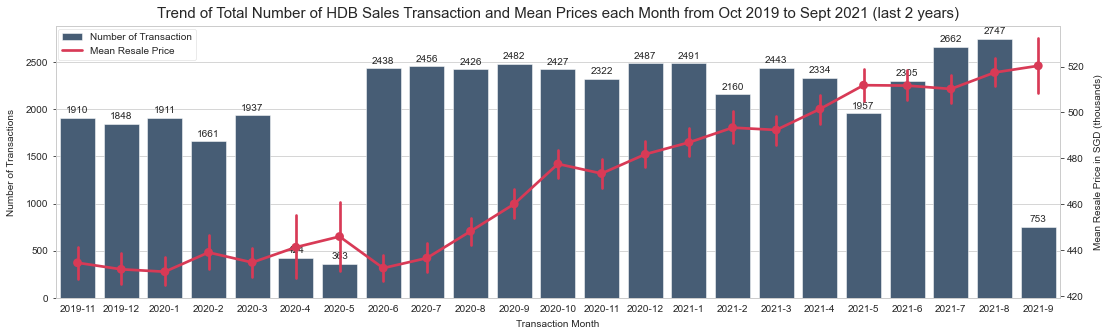

In [9]:
fig, ax = plt.subplots(figsize=(18,5))

sns.countplot(x="trans_date",data=df,
              ax=ax, color='#3F5D7D')
ax2 = ax.twinx()
sns.pointplot(x="trans_date", y="resale_price",
              data=df,
              ax=ax2, color="#D83A56")

fig.patch.set_facecolor('xkcd:white')
ax.spines[["top","right"]].set_visible(False)  
ax2.grid(False)
              
ax.set_title("Trend of Total Number of HDB Sales Transaction and Mean Prices each Month from Oct 2019 to Sept 2021 (last 2 years)",
            fontsize=15, fontweight=10,
            pad=8)
ax.set_xlabel("Transaction Month",
            fontsize=10, fontweight=15,
            labelpad=6)
ax.set_ylabel("Number of Transactions",
            fontsize=10, fontweight=15,
            labelpad=10)
ax2.set_ylabel("Mean Resale Price in SGD (thousands)",
            fontsize=10, fontweight=15,
            labelpad=10)
fig.legend(labels=['Number of Transaction','Mean Resale Price'],
            loc="center", bbox_to_anchor=(0.18, 0.83))
ax.axes.set_xticklabels([ f"{date.year}-{date.month}" for date in df.trans_date.unique()])

# Label Countplots (top of bar)
for p in ax.patches:
    height = p.get_height()
    ax.text(x = p.get_x()+(p.get_width()/2),
            y = height+50,
            s = "{:.0f}".format(height),
            ha = "center")
plt.xticks(rotation=10)
fig.show()

### Some observations for the figure above:
- Overall increasing trend for the last 2 years, but not linearly.
- No obvious seasonality 
- Resale prices does not seem to be affected by the number of transaction (Demand and Supply). 
    - However, this is only a guage as these dataset only shows the transactions and not the number of interested buyers or unsuccessful sellers.
    - Low number of transaction in April and May 2020 is due to circuit breaker in Singapore, where there were minimum interactions.

## Part 2: Trend of HDB Resale Flat Prices with respect to Time of Transaction for each Flat Type. 
### (Price vs Transaction Date, by Flat Type)
Flat type(i.e Number of Rooms,etc) is an important factor in every home buyer's choice. A further exploration into individual mean HDB resale prices for each flat types in Singapore provides a deeper understanding to how the choice of flat types may affect the resales prices.

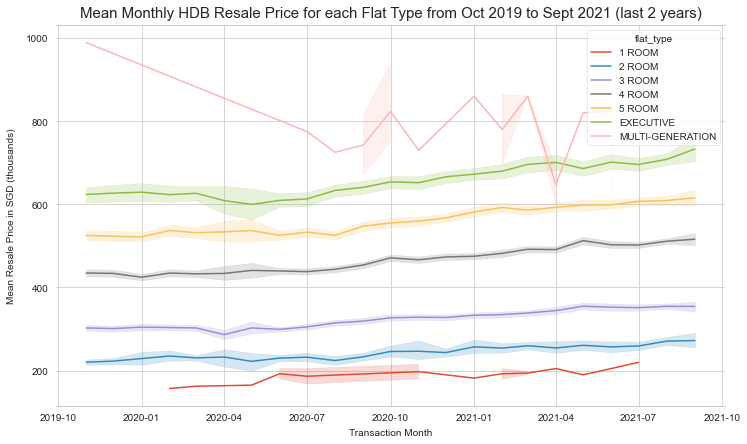

In [10]:
fig, ax = plt.subplots(figsize=(12,7))

sns.lineplot(x="trans_date", y="resale_price",
             data=df, hue="flat_type", ax=ax)

ax.spines[["left","right"]].set_visible(False)  
fig.patch.set_facecolor('xkcd:white')

ax.set_title("Mean Monthly HDB Resale Price for each Flat Type from Oct 2019 to Sept 2021 (last 2 years)",
            fontsize=15, fontweight=30,
            pad=8)
ax.set_xlabel("Transaction Month",
            fontsize=10, fontweight=15,
            labelpad=6)
ax.set_ylabel("Mean Resale Price in SGD (thousands)",
            fontsize=10, fontweight=15,
            labelpad=10)

fig.show()

### Some observations for the figure above:
- A linear trend can be see most all flat types except the "Multi-Generation".
    - This attributes to the overall linear increase in resale prices.
- Non-linearity in the "Multi-Generation" flat types can be see as the main cause of fluctuation in overall trend in resale prices.

Hence, with the exception of the "Multi-Generation" flat type, both time of transaction(trans_date) and flat type will be useful in predicting the prices of the flat type.

## Part 3: HDB Resale Flat Prices vs Flat Size
Similarly, choice of floor area is an important factor for a home buyer.

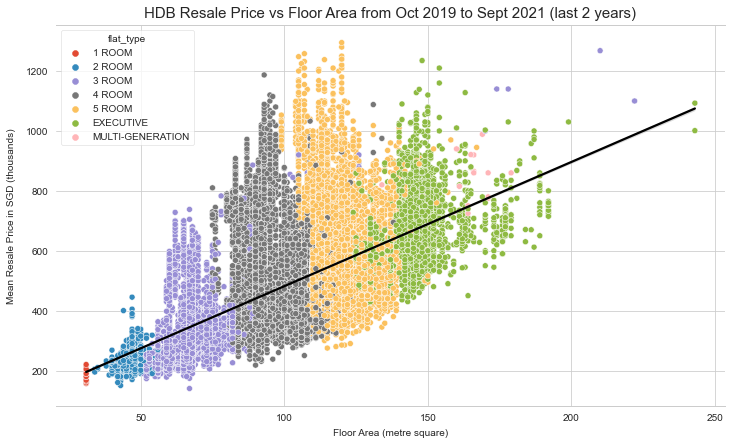

In [11]:
fig, ax = plt.subplots(figsize=(12,7))

sns.scatterplot(x="floor_area_sqm", y="resale_price", hue="flat_type",
                data=df, ax=ax)
sns.regplot(x="floor_area_sqm", y="resale_price", color='black',
                data=df, ax=ax, scatter=False)

fig.patch.set_facecolor('xkcd:white')
ax.spines[["left","right"]].set_visible(False)

ax.set_title("HDB Resale Price vs Floor Area from Oct 2019 to Sept 2021 (last 2 years)",
            fontsize=15, fontweight=30,
            pad=8)
ax.set_xlabel("Floor Area (metre square)",
            fontsize=10, fontweight=15,
            labelpad=6)
ax.set_ylabel("Mean Resale Price in SGD (thousands)",
            fontsize=10, fontweight=15,
            labelpad=10)

fig.show()

### Some observations for the figure above:
- Floor area increases with increasing room size, with executive being the biggest.
- Resale price tends to increase with floor area.
- However, floor size is may not be an major factor due to the large range of possible resale prices(vertical range) it can lie after 50m^2.

## Part 4: HDB Resale Flat Prices vs Storey Range
Choice of which floor to live in may play a part in resale price of the flat. Usually, resale prices will be higher on the higher floors due to a better view and less noise pollution from the surrounding ground floor.

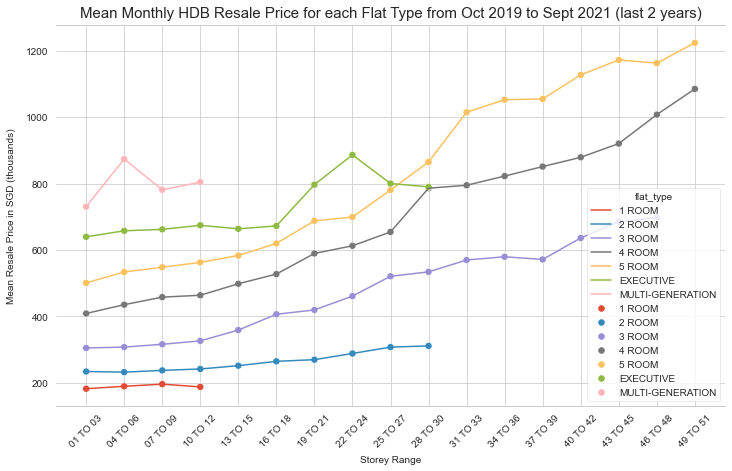

In [12]:
fig, ax = plt.subplots(figsize=(12,7))
fig.patch.set_facecolor('xkcd:white')
data = df.groupby(["flat_type","storey_range"]).mean().reset_index()

sns.scatterplot(x="storey_range", y="resale_price", marker='o', s=50,
             data=data,hue="flat_type", ax=ax)
sns.lineplot(x="storey_range", y="resale_price",
             data=data,hue="flat_type", ax=ax)

ax.spines[["left","right"]].set_visible(False)  
ax.set_title("Mean Monthly HDB Resale Price for each Flat Type from Oct 2019 to Sept 2021 (last 2 years)",
            fontsize=15, fontweight=30,
            pad=8)
ax.set_xlabel("Storey Range",
            fontsize=10, fontweight=15,
            labelpad=6)
ax.set_ylabel("Mean Resale Price in SGD (thousands)",
            fontsize=10, fontweight=15,
            labelpad=10)
plt.xticks(rotation=45)
fig.show()

### Observations:
- An overall linear trend can be seen in each flat type, except 1 room flats.
- A flatter trend can seen in 1 and 2 room flats due to the government's effort to keep prices low for seniors and low-income families.

(https://www.straitstimes.com/singapore/housing/prime-areas-to-be-kept-diverse-and-inclusive-with-range-of-hdb-flat-types-for)

# Machine Learning Part 1
In this section, we will creating machine learning models. We will not be using "block" and "street_name" columns of our dataset because prediction using possibly new values that are not in the current dataset will cause errors and inaccuracies in the future. (i.e New blocks in new locations will be built.)

*Take note that we need to convert the transaction date(trans_date) to numeric values to ensure that we can take in future values.

(Since we are not approaching this question as a time series problem)

In [91]:
df.loc[:,"month_offset"] = pd.to_datetime(df.trans_date)
print(df.iloc[-1,-1])
df.loc[:,"month_offset"] = round((df.month_offset - df.iloc[-1,-1]).dt.days/30)
df.head()

2021-09-01 00:00:00


trans_date lease_commence_date  remaining_lease         town  \
0  2019-10-01          1979-01-01        58.666667   ANG MO KIO   
1  2019-10-01          1989-01-01        68.083333    WOODLANDS   
2  2019-10-01          2000-01-01        79.750000  JURONG WEST   
3  2019-10-01          2000-01-01        79.750000  JURONG WEST   
4  2019-10-01          2001-01-01        80.083333  JURONG WEST   

         street_name block storey_range  flat_model flat_type  floor_area_sqm  \
0  ANG MO KIO AVE 10   406     10 TO 12    improved    2 ROOM            44.0   
1    WOODLANDS ST 31   312     04 TO 06  simplified    4 ROOM            84.0   
2  JURONG WEST ST 64  668A     07 TO 09    model a2    4 ROOM            90.0   
3  JURONG WEST ST 64  668D     01 TO 03    model a2    4 ROOM            85.0   
4  JURONG WEST ST 64  660B     16 TO 18     model a    4 ROOM            91.0   

   resale_price       lat        long  mrt_1km  sch_1km  pri_1km  pri_2km  \
0       223.000  1.362005  103.853880        0        3        2        9   
1       295.000  1.430688  103.775652        1        5        2        7   
2       413.888  1.341831  103.702881        2        7        4       11   
3       324.000  1.341258  103.703001        2        7        4       11   
4       428.000  1.336206  103.704177        2        4        2       11   

   mall_1km  month_offset  
0         0         -23.0  
1         1         -23.0  
2         3         -23.0  
3         2         -23.0  
4         2         -23.0

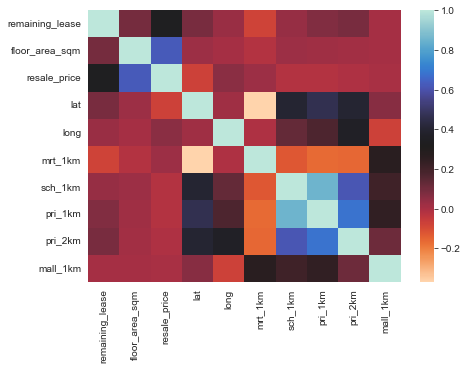

In [68]:
fig = plt.figure(figsize=(7,5))
fig.patch.set_facecolor('xkcd:white')
sns.heatmap(df.corr(),cmap='icefire_r')
plt.show()

In [16]:
# Basic Testing Pipeline
def ML_pipeline(data,model,num_vars,cat_vars,tree=False):
    data_pipeline = ColumnTransformer([
                    ('numerical', StandardScaler(), num_vars),
                    ('categorical', OrdinalEncoder(), cat_vars)
                    ])
    X_processed = data_pipeline.fit_transform(data)
    y = data.loc[:,'resale_price']

    X_train, X_test, y_train, y_test = train_test_split(X_processed, y,
                                                        test_size=.2,random_state=123)
    
    # Cross Validation Results
    scores = cross_validate(model, X_train, y_train,
                            scoring=["r2","neg_root_mean_squared_error"],
                            cv=5, n_jobs=-1)
    print("5CV R2 Score: {}".format( np.mean(scores['test_r2'])) )
    print("5CV RSME Score: {}".format(-1*
            np.mean(scores['test_neg_root_mean_squared_error'])) )

    # Test Results
    model.fit(X_train,y_train)
    print("Test R2 Score: {}".format(model.score(X_test,y_test)))
    print("Test RMSE Score: {}\n".format( 
         mean_squared_error(y_test,model.predict(X_test),squared=False)))

    if tree:
        try:
            print("Preparing SHAP analysis.")
            explainer = shap.TreeExplainer(model)
    
            shap_values = explainer.shap_values(X_test[:100])
            Xcolumns = num_vars + cat_vars
            fig = plt.figure(figsize=(12,7))
            shap.summary_plot(shap_values, X_test[:100],
                                Xcolumns, plot_type="bar",show=False)
            fig.patch.set_facecolor('xkcd:white')
            fig.show()
        except:
            print("Failed. No SHAP analysis. Only for Tree models.")

    return model

In [15]:
# Choice of Features
num_vars = ['floor_area_sqm','remaining_lease',"month_offset"]
cat_vars = ['town', 'storey_range',
            'flat_model', 'flat_type']

In [16]:
print("Testing w/ RF Regressor Model")
ML_pipeline(df, RandomForestRegressor(random_state=123),
            num_vars,cat_vars)

Testing w/ RF Regressor Model
5CV R2 Score: 0.932898890273037
5CV RSME Score: 41.20869905253422
Test R2 Score: 0.9396568879159997
Test RMSE Score: 39.94166579456954



RandomForestRegressor(random_state=123)

In [17]:
print("Testing w/ Linear Regression Model")
ML_pipeline(df, Ridge(random_state=123),
            num_vars,cat_vars)

Testing w/ Linear Regression Model
5CV R2 Score: 0.6142070753421051
5CV RSME Score: 98.81486326663783
Test R2 Score: 0.628436030923156
Test RMSE Score: 99.11265681311731



Ridge(random_state=123)

Testing w/ XGBR Regressor Model
5CV R2 Score: 0.9440822345223804
5CV RSME Score: 37.616035846215155
Test R2 Score: 0.9503124626248961
Test RMSE Score: 36.243994650021854

Preparing SHAP analysis.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

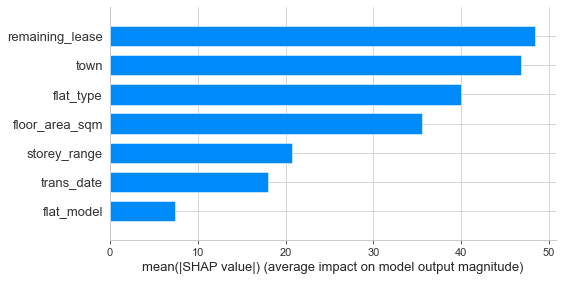

In [18]:
print("Testing w/ XGBR Regressor Model")
ML_pipeline(df, xgb.XGBRegressor(),
            num_vars,cat_vars,True)

## Observation:
- The XGboost model provides the best results among 3 models in terms of highest R^2 value and lowest RSME for both cross validation and test set result.
- According to SHAP, Remaining_lease, town and flat type are the most important factors in determining resale price.
- Flat_model is the least important factor as it is a subset of the flat types.

# Feature Engineering
After browsing articles, property market sites and social media, 3 additional features are found to be potential features to improve our model.

    1. Nearby MRTs (within 1km radius)
    2. Nearby Schools (within 1km radius)
    3. Nearby Primary Schools (within 1km and 2km radius)
        - Within 1km and 2km radius gives higher priority during balloting
        ( https://www.moe.gov.sg/primary/p1-registration/distance/ )
    4. Nearby Malls (within 1km radius)

Assuming a straight line walking route, it takes about 12mins to walk 1km according to the calculation below. In order to determine the actual land distance, we can use geocoordinates from Singapore's onemap API to determine lat and long distance and convert it using a multiplier with respect to Singapore location. 

In [19]:
# Start onemap client
Client = OneMapClient(creds.email,creds.password)

def countdown(count,start):
    # Sleep counter abides onemap's rules (max 250 query/s)
    count += 1
    if count >= 250:
        end = time.time()
        time.sleep(end-start)
        start = time.time()
        count = 0
    return count,start

# Distance Multiplier Calculation
latlong_dist = np.sqrt(0.1**2 + 0.1**2) # 0.1 lat and 0.1 long difference
actual_dist_m = 15.723 * 1000 # According to https://latlongdata.com/distance-calculator/
latlong_multiplier = actual_dist_m/latlong_dist

# Assuming average walking speed as 1.4m/s 
# (according to https://www.healthline.com/health/exercise-fitness/average-walking-speed#average-speed-by-age)
kmpermin = (1.4/1000) * 60
print(f"Expected time for 1km walking distance: {1/kmpermin}")

Expected time for 1km walking distance: 11.904761904761903


## Preparing MRT dataset
Dataset can be downloaded directly from the Singapore data gov website at https://data.gov.sg/dataset/train-station-chinese-names or it can be accessed via API below.

In [20]:
# Import Dataset via API
url = 'https://data.gov.sg/api/action/datastore_search?resource_id=65c1093b-0c34-41cf-8f0e-f11318766298&limit=1000'
response = requests.get(url)
print(f"Response Code : {response.status_code}")
mrt_df = pd.json_normalize(response.json()['result']['records'])
mrt_df = mrt_df.loc[:,["mrt_station_english","mrt_line_english"]]
mrt_df.columns = ["station","line"]
mrt_df = mrt_df.loc[mrt_df.line.str.contains("Line"),:] # remove LRTs
mrt_df.head()

Response Code : 200


station              line
0    Jurong East  North South Line
1    Bukit Batok  North South Line
2   Bukit Gombak  North South Line
3  Choa Chu Kang  North South Line
4        Yew Tee  North South Line

In [21]:
# Adding Longitude and Lattitude Data
mrt_df.loc[:,"lat"] = ""
mrt_df.loc[:,"long"] = ""
start = time.time()
count = 0
for i,row in tqdm(mrt_df.iterrows(), total=mrt_df.shape[0]):
    station_name = row["station"] + " MRT"
    try:
        search = Client.search(station_name,page_num=1)["results"][0]
        mrt_df.loc[i,"lat"] = search["LATITUDE"]
        mrt_df.loc[i,"long"] = search["LONGITUDE"]
        count,start = countdown(count,start)
    except:
        continue
mrt_df.loc[mrt_df.lat.isna(),:] # Checking for any entries with no geo location

100%|██████████| 141/141 [00:41<00:00,  3.39it/s]


Empty DataFrame
Columns: [station, line, lat, long]
Index: []

In [22]:
# mrt_df = pd.read_csv("dataset/mrt_geo.csv") # If no access to onemap
mrt_df.head()

station              line               lat              long
0    Jurong East  North South Line  1.33315281585758  103.742286332403
1    Bukit Batok  North South Line  1.34903331201636  103.749566478309
2   Bukit Gombak  North South Line  1.35861159094192  103.751790910733
3  Choa Chu Kang  North South Line  1.38536316540225  103.744370779756
4        Yew Tee  North South Line  1.39753506936297  103.747405150236

In [23]:
mrt_df = mrt_df.dropna(axis=0)
mrt_df.lat = mrt_df.lat.astype(np.float)
mrt_df.long = mrt_df.long.astype(np.float)
mrt_df.to_csv("dataset/mrt_geo.csv",index=False)

## Preparing Schools Dataset
Dataset can be downloaded directly from the Singapore data gov website at https://data.gov.sg/dataset/school-directory-and-information?view_id=ba7c477d-a077-4303-96a1-ac1d4f25b190&resource_id=ede26d32-01af-4228-b1ed-f05c45a1d8ee or it can be accessed via API below.

In [24]:
# Import Dataset via API
url = 'https://data.gov.sg/api/action/datastore_search?resource_id=ede26d32-01af-4228-b1ed-f05c45a1d8ee&limit=1000'
response = requests.get(url)
print(f"Response Code : {response.status_code}")
school_df = pd.json_normalize(response.json()['result']['records'])
school_df = school_df.loc[:,["school_name","postal_code","mainlevel_code"]]
school_df.head()

Response Code : 200


school_name postal_code mainlevel_code
0        ADMIRALTY PRIMARY SCHOOL      738907        PRIMARY
1      ADMIRALTY SECONDARY SCHOOL      737916      SECONDARY
2    AHMAD IBRAHIM PRIMARY SCHOOL      768643        PRIMARY
3  AHMAD IBRAHIM SECONDARY SCHOOL      768928      SECONDARY
4                  AI TONG SCHOOL      579646        PRIMARY

In [25]:
# Adding Longitude and Lattitude Data
school_df.loc[:,"lat"] = ""
school_df.loc[:,"long"] = ""
start = time.time()
count = 0
for i,row in tqdm(school_df.iterrows(), total=school_df.shape[0]):
    postal_code = row["postal_code"]
    if len(str(postal_code))<6:
        postal_code = (6-len(str(postal_code)))*"0" + str(postal_code)

    try:
        search = Client.search(postal_code,page_num=1)["results"][0]
        school_df.loc[i,"lat"] = search["LATITUDE"]
        school_df.loc[i,"long"] = search["LONGITUDE"]
        count,start = countdown(count,start)
    except:
        continue
school_df.loc[school_df.lat.isna(),:]

100%|██████████| 346/346 [02:43<00:00,  2.12it/s]


Empty DataFrame
Columns: [school_name, postal_code, mainlevel_code, lat, long]
Index: []

In [55]:
school_df = pd.read_csv("dataset/schools_geo.csv") # If no access to onemap
school_df.head()

school_name  postal_code mainlevel_code       lat  \
0        ADMIRALTY PRIMARY SCHOOL       738907        PRIMARY  1.442635   
1      ADMIRALTY SECONDARY SCHOOL       737916      SECONDARY  1.445891   
2    AHMAD IBRAHIM PRIMARY SCHOOL       768643        PRIMARY  1.433414   
3  AHMAD IBRAHIM SECONDARY SCHOOL       768928      SECONDARY  1.436060   
4                  AI TONG SCHOOL       579646        PRIMARY  1.360583   

         long  
0  103.800040  
1  103.802398  
2  103.832750  
3  103.829719  
4  103.833020

In [56]:
school_df = school_df.dropna(axis=0)
school_df.lat = school_df.lat.astype(np.float)
school_df.long = school_df.long.astype(np.float)
school_df.to_csv("dataset/schools_geo.csv",index=False)

## Preparing Malls Dataset
The list of malls are found by webscraping the wikipedia page due to no such central dataset in any government source.

In [45]:
url = "https://en.wikipedia.org/wiki/List_of_shopping_malls_in_Singapore"
response = requests.get(url=url)
print(f"Response Code : {response.status_code}")
soup = BeautifulSoup(response.content, 'html.parser')
all_region = soup.find(id="mw-content-text")
mall_list = []
for region in all_region:
    items = all_region.find_all("ul")
    for item in items[:8]:
        for mall in item.select("li"):
            mall_list.append(str(mall.string))
mall_list = sorted(set(mall_list))
mall_df = pd.DataFrame(mall_list,columns=["mall"])
mall_df.head()

Response Code : 200


mall
0        100 AM
1  313@Somerset
2  321 Clementi
3     888 Plaza
4       AMK Hub

In [46]:
mall_df = pd.DataFrame(mall_list,columns=["mall"])
mall_df.loc[:,"lat"] = ""
mall_df.loc[:,"long"] = ""
start = time.time()
count = 0
for i,row in tqdm(mall_df.iterrows(), total=mall_df.shape[0]):
    mall = row["mall"]
    try:
        search = Client.search(mall,page_num=1)["results"][0]
        mall_df.loc[i,"lat"] = search["LATITUDE"]
        mall_df.loc[i,"long"] = search["LONGITUDE"]
        count,start = countdown(count,start)
    except:
        continue
mall_df.loc[mall_df.lat.isna(),:]

100%|██████████| 170/170 [00:43<00:00,  3.95it/s]


mall  lat long
29                            City Gate Mall  NaN  NaN
33                       Clarke Quay Central  NaN  NaN
55             Holland Village Shopping Mall  NaN  NaN
69                    KINEX (formerly OneKM)  NaN  NaN
89                   Mustafa Shopping Centre  NaN  NaN
92                                      None  NaN  NaN
94                                   OD Mall  NaN  NaN
102                 Paya Lebar Quarter (PLQ)  NaN  NaN
108                                     PoMo  NaN  NaN
120                    Shaw House and Centre  NaN  NaN
122  Singapore Post Centre (Singpost Centre)  NaN  NaN
150                   Velocity@Novena Square  NaN  NaN
165                  Yew Tee Shopping Centre  NaN  NaN

Take note that some of the malls are not found using onemap's api. Therefore, lat and long are inputted manually using google map.

In [57]:
mall_df = pd.read_csv("dataset/malls_geo.csv") # after manual input 
mall_df.head()

mall       lat        long
0        100 AM  1.274588  103.843471
1  313@Somerset  1.301385  103.837684
2  321 Clementi  1.312002  103.764987
3     888 Plaza  1.437123  103.795314
4       AMK Hub  1.369389  103.848478

In [49]:
mall_df = mall_df.dropna(axis=0)
mall_df.lat = mall_df.lat.astype(np.float)
mall_df.long = mall_df.long.astype(np.float)
mall_df.to_csv("dataset/malls_geo.csv",index=False)

## Adding Geocoordinates to the Original Dataset
The algorithm will attempt several naming convention of each entry to find the the most exact geocoordinates using onemap's api.

In [32]:
df.loc[:,"lat"] = ""
df.loc[:,"long"] = ""
count = 0
start = time.time()
for i,row in tqdm(df2.iterrows(), total=df2.shape[0]):
    if row["lat"] == "":
        block = row["block"]
        street = row["street_name"]
        location = block + " " + street # "123 Charming Street Ave 2"
        index_ = df2.loc[(df2.street_name==street) &
                        (df2.block==block),:].index

        try:
            search = Client.search(location,page_num=1)["results"][0]
            df2.iloc[index_,-2] = search["LATITUDE"]
            df2.iloc[index_,-1] = search["LONGITUDE"]
        count,start = countdown(count,start)
        except:
            try:
                location = street  # "Charming Street Ave 2"
                search = Client.search(location,page_num=1)["results"][0]
                df2.iloc[index_,-2] = search["LATITUDE"]
                df2.iloc[index_,-1] = search["LONGITUDE"]
                count,start = countdown(count,start)
            except:
                try:
                    town = row["town"]
                    location = block + " " + town  # "123 Hougang"
                    search = Client.search(location,page_num=1)["results"][0]
                    df2.iloc[index_,-2] = search["LATITUDE"]
                    df2.iloc[index_,-1] = search["LONGITUDE"]
                    count,start = countdown(count,start)
                except:
                    print(location)
                    continue
df.loc[df.lat.isna(),:]

In [33]:
# Second round of iteration is required as sometimes the onemap api do not return a geolocation despite it being found before.
for i,row in df.loc[df.lat.isna(),:].iterrows():
    street_name = row["street_name"]
    block = row["block"]

    # Check if there is other rows that gotten a result
    search_df = df.loc[(df.street_name==street_name) &
                         (df.block==block),:]
    if len(search_df)>1: # Yes, there is others
        for j,row2 in search_df.iterrows():
            if ~np.isnan(row2["lat"]):
                df.loc[i,["lat","long"]] = df.loc[j,["lat","long"]]
                break
    elif ~block[-1].isdigit(): # check if last char of block is a str
        # check for other results
        search_df = df.loc[(df.street_name==street_name) &
                            (df.block.str.contains(block[:-1])),:]
        if len(search_df)>1: # Yes, there is others
            for j,row2 in search_df.iterrows():
                if ~np.isnan(row2["lat"]):
                    df.loc[i,["lat","long"]] = df.loc[j,["lat","long"]]
                    break
        else: # no results
            try:
                location = street_name + " " + block[:-1] # find directly from onemap
                search = Client.search(location,page_num=1)["results"][0]
                df.loc[i,"lat"] = search["LATITUDE"]
                df.loc[i,"long"] = search["LONGITUDE"]
            except:
                print("Not found")

    if np.isnan(df.loc[i,"lat"]):
        print(f"{street_name} at {block}")
df.loc[df.lat.isna(),:]

In [34]:
df = pd.read_csv("dataset/df_geo.csv")
df.head()

trans_date lease_commence_date  remaining_lease         town  \
0  2019-10-01          1979-01-01        58.666667   ANG MO KIO   
1  2019-10-01          1989-01-01        68.083333    WOODLANDS   
2  2019-10-01          2000-01-01        79.750000  JURONG WEST   
3  2019-10-01          2000-01-01        79.750000  JURONG WEST   
4  2019-10-01          2001-01-01        80.083333  JURONG WEST   

         street_name block storey_range  flat_model flat_type  floor_area_sqm  \
0  ANG MO KIO AVE 10   406     10 TO 12    improved    2 ROOM            44.0   
1    WOODLANDS ST 31   312     04 TO 06  simplified    4 ROOM            84.0   
2  JURONG WEST ST 64  668A     07 TO 09    model a2    4 ROOM            90.0   
3  JURONG WEST ST 64  668D     01 TO 03    model a2    4 ROOM            85.0   
4  JURONG WEST ST 64  660B     16 TO 18     model a    4 ROOM            91.0   

   resale_price       lat        long  
0       223.000  1.362005  103.853880  
1       295.000  1.430688  103.775652  
2       413.888  1.341831  103.702881  
3       324.000  1.341258  103.703001  
4       428.000  1.336206  103.704177

In [35]:
df.dtypes

trans_date              object
lease_commence_date     object
remaining_lease        float64
town                    object
street_name             object
block                   object
storey_range            object
flat_model              object
flat_type               object
floor_area_sqm         float64
resale_price           float64
lat                    float64
long                   float64
dtype: object

In [36]:
df.to_csv('dataset/df_geo.csv',index=False)

## Adding Features into Main Dataset
New Features:

    1. Nearby MRTs (within 1km radius)
    2. Nearby Schools (within 1km radius)
    3. Nearby Primary Schools (within 1km and 2km radius)
        - Within 1km and 2km radius gives higher priority during balloting
        ( https://www.moe.gov.sg/primary/p1-registration/distance/ )
    4. Nearby Malls (within 1km radius)

In [37]:
def find_nearby(row,data,multiplier,dist=1000,rules=""):
    start = row[["lat","long"]].values
    destination = data.loc[:,["lat","long"]]
    sumofsqs = ((start-destination)**2).sum(axis=1) # pythagoras theorem
    latlong_dist = np.sqrt(sumofsqs) 
    actual_dist = latlong_dist*multiplier # convert to actual distance
    if rules=="":
        counts = sum(actual_dist<dist)
    else:
        counts = sum((actual_dist<dist) & (data.loc[:,rules[0]] == rules[1]))
    return counts

In [58]:
 df.loc[:,["mrt_1km","sch_1km","pri_1km","pri_2km","mall_1km"]] = ""
for i,row in tqdm(df.iterrows(), total=df.shape[0]):
    df.loc[i,"mrt_1km"] = find_nearby(row,mrt_df,latlong_multiplier)
    df.loc[i,"sch_1km"] = find_nearby(row,school_df,latlong_multiplier)
    df.loc[i,"pri_1km"] = find_nearby(row,school_df,latlong_multiplier,
                                        1000, ("mainlevel_code","PRIMARY"))
    df.loc[i,"pri_2km"] = find_nearby(row,school_df,latlong_multiplier,
                                        2000, ("mainlevel_code","PRIMARY"))
    df.loc[i,"mall_1km"] = find_nearby(row,mall_df,latlong_multiplier)

100%|██████████| 49129/49129 [07:36<00:00, 107.52it/s]


In [60]:
df.head()

trans_date lease_commence_date  remaining_lease         town  \
0  2019-10-01          1979-01-01        58.666667   ANG MO KIO   
1  2019-10-01          1989-01-01        68.083333    WOODLANDS   
2  2019-10-01          2000-01-01        79.750000  JURONG WEST   
3  2019-10-01          2000-01-01        79.750000  JURONG WEST   
4  2019-10-01          2001-01-01        80.083333  JURONG WEST   

         street_name block storey_range  flat_model flat_type  floor_area_sqm  \
0  ANG MO KIO AVE 10   406     10 TO 12    improved    2 ROOM            44.0   
1    WOODLANDS ST 31   312     04 TO 06  simplified    4 ROOM            84.0   
2  JURONG WEST ST 64  668A     07 TO 09    model a2    4 ROOM            90.0   
3  JURONG WEST ST 64  668D     01 TO 03    model a2    4 ROOM            85.0   
4  JURONG WEST ST 64  660B     16 TO 18     model a    4 ROOM            91.0   

   resale_price       lat        long mrt_1km sch_1km pri_1km pri_2km mall_1km  
0       223.000  1.362005  103.853880       0       3       2       9        0  
1       295.000  1.430688  103.775652       1       5       2       7        1  
2       413.888  1.341831  103.702881       2       7       4      11        3  
3       324.000  1.341258  103.703001       2       7       4      11        2  
4       428.000  1.336206  103.704177       2       4       2      11        2

# Machine Learning Part 2

In [55]:
# Choice of Features
num_vars = ['floor_area_sqm','remaining_lease',"month_offset",
            "pri_1km","pri_2km","sch_1km",
            "mrt_1km","mall_1km"]

cat_vars = ['town', 'storey_range',
            'flat_model', 'flat_type']

In [56]:
print("Testing w/ RF Regressor Model")
ML_pipeline(df, RandomForestRegressor(random_state=123),
            num_vars,cat_vars,"")

Testing w/ RF Regressor Model
5CV R2 Score: 0.9251582030837378
5CV RSME Score: 43.53556397351141
Test R2 Score: 0.9345902909854034
Test RMSE Score: 41.1116827192183



RandomForestRegressor(random_state=123)

Testing w/ XGBR Regressor Model
5CV R2 Score: 0.9422276816790859
5CV RSME Score: 38.24790824319662
Test R2 Score: 0.9454513110957006
Test RMSE Score: 37.543633596785256

Preparing SHAP analysis.


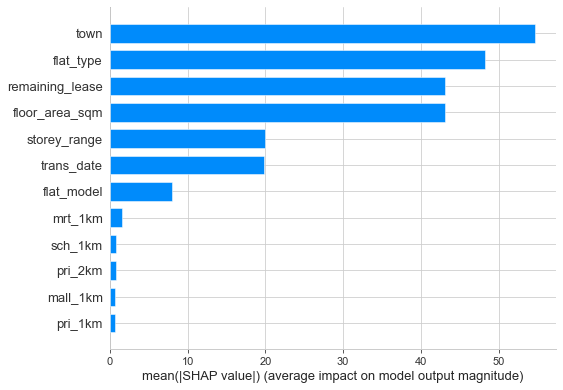

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [57]:
print("Testing w/ XGBR Regressor Model")
ML_pipeline(df, xgb.XGBRegressor(),
            num_vars,cat_vars,True)

### Previous best model(XGBoost):
- 5CV R2 Score: 0.9440822345223804
- 5CV RSME Score: 37.616035846215155
- Test R2 Score: 0.9503124626248961
- Test RMSE Score: 36.243994650021854


### Observations:
- Both models with additional new features engineered provided no improvement to the previous models.
- Low SHAP value for all 6 new features indicates that MRTs, Schools and Malls in close proximity does not affect the resale price of HDBs

In [72]:
# Saving Model into a pickle
num_vars = ['floor_area_sqm','remaining_lease',"month_offset"]
cat_vars = ['town', 'storey_range',
            'flat_model', 'flat_type']
transform = ColumnTransformer([
                    ('numerical', StandardScaler(), num_vars),
                    ('categorical', OrdinalEncoder(), cat_vars)
                    ])
pipeline = Pipeline(steps=[("Transforming",transform),
                            ("Fitting",xgb.XGBRegressor())],
                            verbose=True)

pipeline.fit(df,df.resale_price)
joblib.dump(pipeline, 'pipeline.pkl')

# Saving final df
df.to_csv("dataset/df_final.csv",index=False)


[Pipeline] ...... (step 1 of 2) Processing Transforming, total=   0.1s
[Pipeline] ........... (step 2 of 2) Processing Fitting, total=   0.8s


# Conclusion and Future Improvements

## Discovery
Using the original dataset and engineered features, we discovered the major factors that affect HDB resales price such as the location, the flat type and the remaining lease of the flat. Features such as proximity to schools, malls and MRTS are heavily marketed in social media and property markets. As these features do not greatly affect the price of HDBs, they remain as a attractive selling point. The next time you buy a HDB resale flat in Singapore, make sure you have these features because it will mean you that you getting the most bang for the buck!

## Technique Used:
- Data Wrangling
- API retrieval (onemap and data.gov.sg)
- Webscaping (wikipedia)
- Machine Learning Modelling
- Feature Engineering (via contextual knowledge)



## Possible Future Improvements
- Further Optimisation for Machine Models
- Time Series Analysis
- Optimising and Finding more possible Features